In [86]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import sys 
import os

root_path = 'C://Users//HP//projects//DiplomaThesis'
sys.path.append(f'{root_path}')

from plots import LatexFigure
from data import Meta

%load_ext autoreload 
%autoreload 2
%matplotlib inline

meta = Meta()
meta.load()

nn_names_dict = {
    "32":"NN1",
    "32,16":"NN2",
    "32,16,8":"NN3",
    "32,16,8,4":"NN4",
    "32,16,8,4,2":"NN5"
}

def df_heatmap(df, scale=2, vmin=0, vmax=None, cmap=plt.cm.Blues, flip_cbar=False, show_cbar=True):
    %matplotlib inline
    fig, axis = plt.subplots() # il me semble que c'est une bonne habitude de faire supbplots
    heatmap = axis.pcolor(df, cmap=cmap, vmin=vmin, vmax=vmax)
    labels = [meta.sc_to_latex.get(label) for label in df.index.values.tolist()]
    plt.yticks(np.arange(0.5, len(df.index), 1), labels)
    plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
    axis.invert_yaxis()
    axis.xaxis.tick_top()
    if show_cbar:
        cbar = plt.colorbar(heatmap)
        if flip_cbar:
            cbar.ax.invert_yaxis() 
    fig = LatexFigure(plt.gcf())
    fig.fit(scale=scale)

def subset_models(ar, df, hidden_layers=None, ytrain=None):
    if hidden_layers and not ytrain: 
        sub = (ar["hidden_layers"]==hidden_layers) 
    elif ytrain and not hidden_layers: 
        sub = (ar["ytrain"]==ytrain)
    elif ytrain and hidden_layers: 
        sub = (ar["hidden_layers"]==hidden_layers) & (ar["ytrain"]==ytrain)
    else: 
        sub = df.columns
    return df[sub]

def get_corr_of_seeds(ar, df):
    corr = dict()
    for ytrain in [12,13,14,15,16]:
        corr["{}".format(ytrain)] = dict()
        for hidden_layers in ["32","32,16","32,16,8","32,16,8,4","32,16,8,4,2"]:
            sub = (ar["hidden_layers"]==hidden_layers) & (ar["ytrain"]==ytrain)
            corr["{}".format(ytrain)]["{}".format(hidden_layers)] = df[sub].transpose().corr().dropna(how="all").dropna(how="all", axis=1).values.mean()
    return corr

def load_dataframes(fpath):
    ar = pd.read_csv(os.path.join(fpath, "args.csv"), index_col=0)
    pe = pd.read_csv(os.path.join(fpath, "performance.csv"), index_col=0)
    ig = pd.read_csv(os.path.join(fpath, "integrated_gradients_global.csv"), index_col=0)
    mr = pd.read_csv(os.path.join(fpath, "model_reliance.csv"), index_col=0)
    return ar, pe, ig, mr

def name(ar, df, variables):
    old_names = df.columns.tolist()
    lists = [ar.loc[old_names][var].values.astype(str).tolist() for var in variables]
    df.columns = ["-".join(l) for l in list(zip(*lists))]
    df = df.reindex(sorted(df.columns), axis=1)
    return df

def get_orders(row):
    array = row.values
    temp = sorted(list(array))
    res = np.array([temp.index(i) for i in array])
    return pd.Series(res, row.index)

def get_parts(row, nparts):
    array = row.values
    temp = sorted(list(array))
    res = np.array([temp.index(i) for i in array])
    labels = list(reversed((np.arange(nparts)+1)*(30/nparts)))
    return pd.qcut(pd.Series(res, row.index).rank(method='first'),nparts,labels).astype(float)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Ensembles

In [119]:
fpath = os.path.join("results", "ensembles")
ar, pe, ig, mr = load_dataframes(fpath)
SORTING = subset_models(ar, ig, hidden_layers=None, ytrain=16).mean().abs().sort_values(ascending=False).index.tolist()
ig = ig[SORTING]
mr = mr[SORTING]
ar["nn_name"] = ar[["hidden_layers"]].replace(nn_names_dict)
ar["nn_name_short"] = [s[-1:] for s in ar.nn_name]

### Integrated gradients show size of impact of features on the prediction values

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


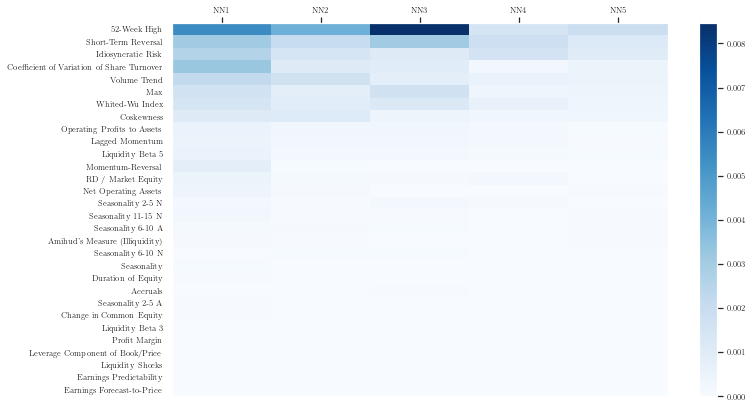

In [90]:
df_heatmap(
    name(
        ar, 
        subset_models(
            ar, ig, hidden_layers=None, ytrain=16
        ).transpose(),
        ["nn_name"]
    ),
    cmap=plt.cm.Blues,
    vmin=0,
    show_cbar=True
)

### Model Reliance shows how distorting a features harms the model's performance

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


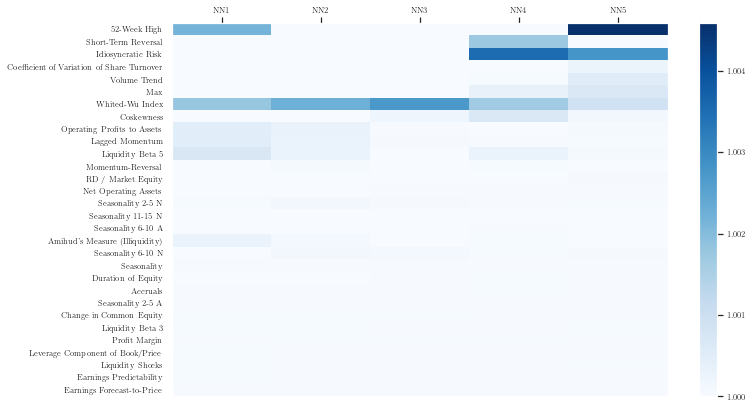

In [91]:
df_heatmap(
    name(
        ar, 
        subset_models(
            ar, mr, hidden_layers=None, ytrain=16
        ).transpose(),
        ["nn_name"]
    ),
    cmap=plt.cm.Blues,
    vmin=1,
    show_cbar=True
)

### All ensembles agree on 10 most influential features (IG)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


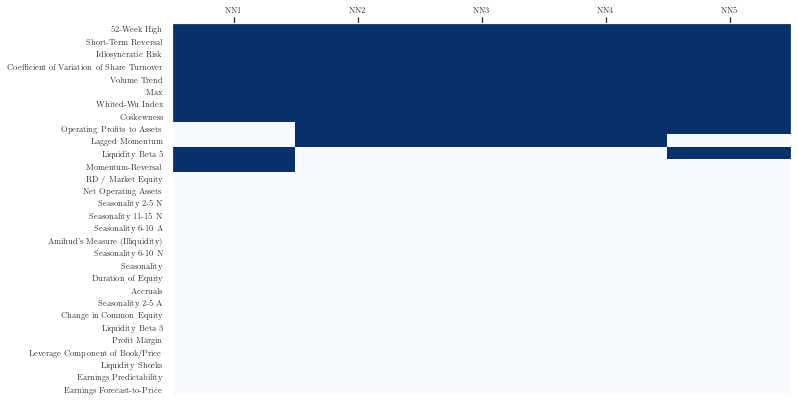

In [92]:
df = (ig.apply(lambda x: get_orders(x), axis=1)>=20)
df_heatmap(
    name(
        ar, 
        subset_models(
            ar, df, hidden_layers=None, ytrain=16
        ).transpose(),
        ["nn_name"]
    ),
    cmap=plt.cm.Blues,
    vmin=0,
    show_cbar=False
)

### All ensembles agree on 10 least influential features (IG)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


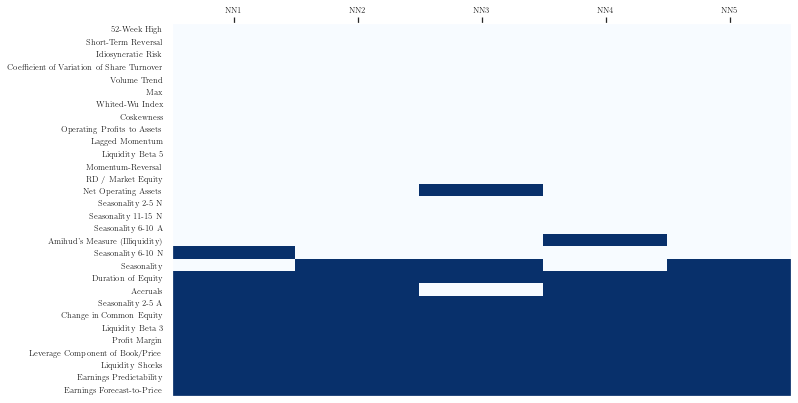

In [93]:
df = (ig.apply(lambda x: get_orders(x), axis=1)<=10)
df_heatmap(
    name(
        ar, 
        subset_models(
            ar, df, hidden_layers=None, ytrain=16
        ).transpose(),
        ["nn_name"]
    ),
    cmap=plt.cm.Blues,
    vmin=0,
    show_cbar=False
)

### All ensembles agree on top and bottom features by influence, but the middle is mixed (IG)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


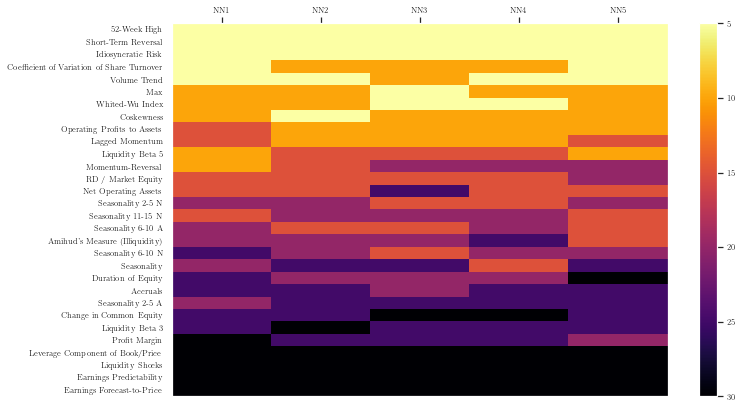

In [95]:
df = ig.apply(lambda x: get_parts(x,6), axis=1)
df_heatmap(
    name(
        ar, 
        subset_models(
            ar, df, hidden_layers=None, ytrain=16
        ).transpose(),
        ["nn_name"]
    ),
    cmap=plt.cm.inferno_r,
    vmin=None,
    flip_cbar=True
)

### While IG are same across models, Model Reliances are different (top 10 features)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


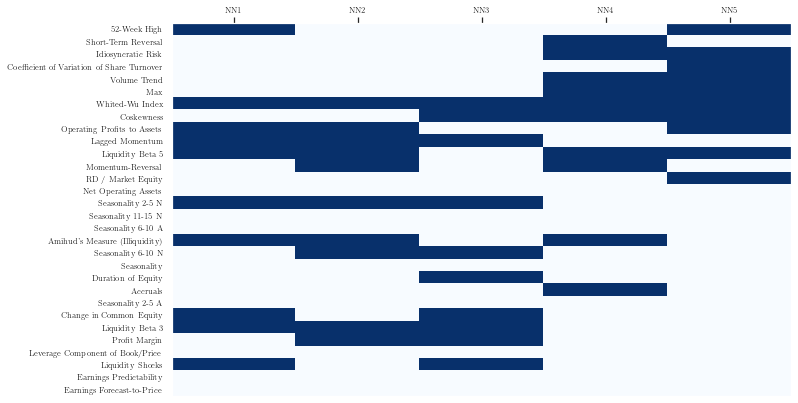

In [97]:
df = (mr.apply(lambda x: get_orders(x), axis=1)>=20)
df_heatmap(
    name(
        ar, 
        subset_models(
            ar, df, hidden_layers=None, ytrain=16
        ).transpose(),
        ["nn_name"]
    ),
    cmap=plt.cm.Blues,
    vmin=0,
    show_cbar=False
)

### While IG are same across models, Model Reliances are different (bottom 10 features)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


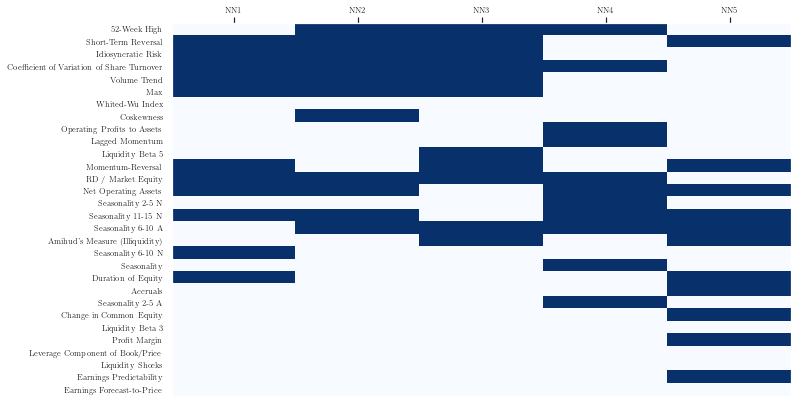

In [98]:
df = (mr.apply(lambda x: get_orders(x), axis=1)<=10)
df_heatmap(
    name(
        ar, 
        subset_models(
            ar, df, hidden_layers=None, ytrain=16
        ).transpose(),
        ["nn_name"]
    ),
    cmap=plt.cm.Blues,
    vmin=0,
    show_cbar=False
)

### Relative importance of features differes across ensembles (MR)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


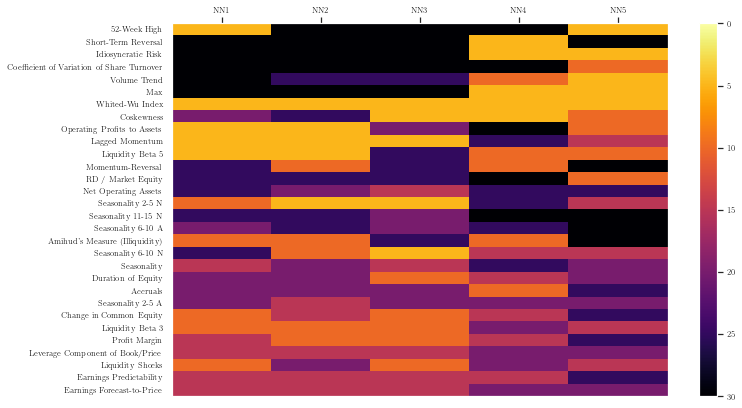

In [99]:
df = mr.apply(lambda x: get_parts(x,6), axis=1)
df_heatmap(
    name(
        ar, 
        subset_models(
            ar, df, hidden_layers=None, ytrain=16
        ).transpose(),
        ["nn_name"]
    ),
    cmap=plt.cm.inferno_r,
    vmin=0,
    flip_cbar=True
)

### Why is MR and IG so different? 
IG is high for features whose **values** have big impact on the **value** of the prediction, if other features are at 0. (It **ignores the correlation** of the features.)

MR is high for features whose **distortion** worsens the **error** of the prediction relative to truth. It **takes into account the correlation** of the features.

The issue is the mirror of that in linear regression, coefficients of a variable (IG) can be big and yet the variable can be insignificant due to multicollinearity and a lot more features present (MR)

### MR and IG agree the more the deeper the model

In [100]:
def compare_mr_ig(hidden_layers):
    df_mr = (mr.apply(lambda x: get_orders(x), axis=1)>=20)
    df_mr = name(
            ar, 
            subset_models(
                ar, df_mr, hidden_layers=hidden_layers, ytrain=16
            ).transpose(),
            ["nn_name"])
    df_ig = (ig.apply(lambda x: get_orders(x), axis=1)>=20)
    df_ig = name(
            ar, 
            subset_models(
                ar, df_ig, hidden_layers=hidden_layers, ytrain=16
            ).transpose(),
            ["nn_name"])
    df = pd.concat([df_ig,df_mr,],axis=1)
    df.columns = ["IG", "MR"]
    return df

In [101]:
overlap_top_10 = dict()
for hl in ["32","32,16","32,16,8", "32,16,8,4", "32,16,8,4,2"]:
    df = compare_mr_ig(hl)
    overlap_top_10[hl] = ((df.IG == True) & (df.MR == True)).sum()
overlap_top_10

{'32': 3, '32,16': 3, '32,16,8': 3, '32,16,8,4': 6, '32,16,8,4,2': 9}

**NN1**

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


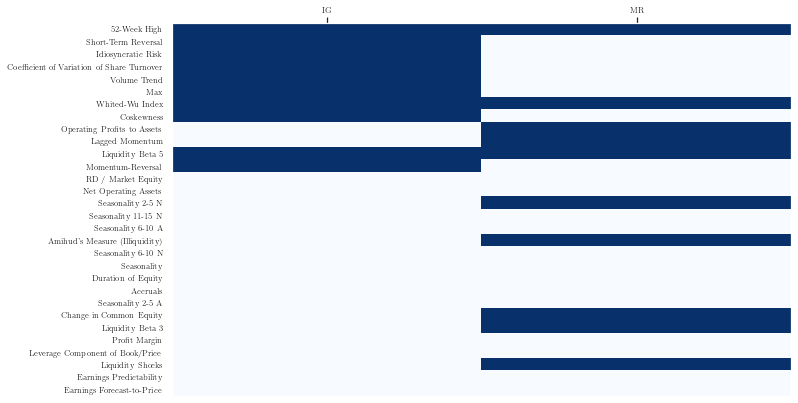

In [102]:
df_heatmap(
    compare_mr_ig("32"),
    cmap=plt.cm.Blues,
    vmin=0,
    show_cbar=False
)

**NN5**

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


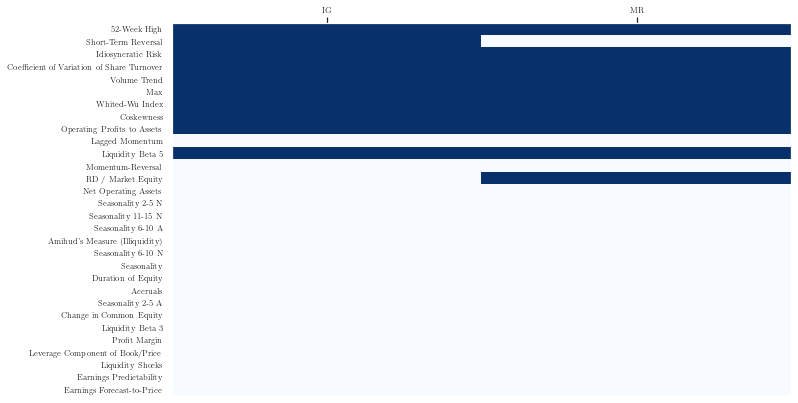

In [103]:
df_heatmap(
    compare_mr_ig("32,16,8,4,2"),
    cmap=plt.cm.Blues,
    vmin=0,
    show_cbar=False
)

# Seeds

In [120]:
fpath = "results/individual"
ar, pe, ig, mr = load_dataframes(fpath)
ig = ig[SORTING]
mr = mr[SORTING]
ar["nn_name"] = ar[["hidden_layers"]].replace(nn_names_dict)
ar["nn_name_short"] = [s[-1:] for s in ar.nn_name]

### Integrated Gradients do not change across seeds (10 most important featues)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


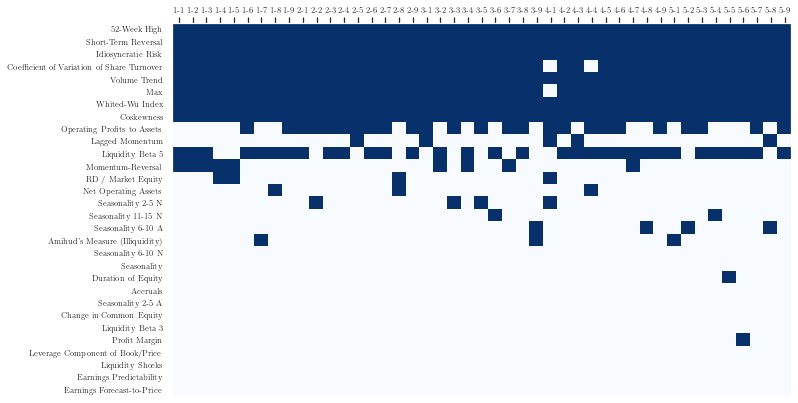

In [121]:
df = (ig.apply(lambda x: get_orders(x), axis=1)>=20)
df_heatmap(
    name(
        ar, 
        subset_models(
            ar, df, hidden_layers=None, ytrain=16
        ).transpose(),
        ["nn_name_short", "seed"]
    ),
    cmap=plt.cm.Blues,
    vmin=0,
    show_cbar=False
)

### Integrated Gradients do not change across seeds (features grouped by importance into categories of 5)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


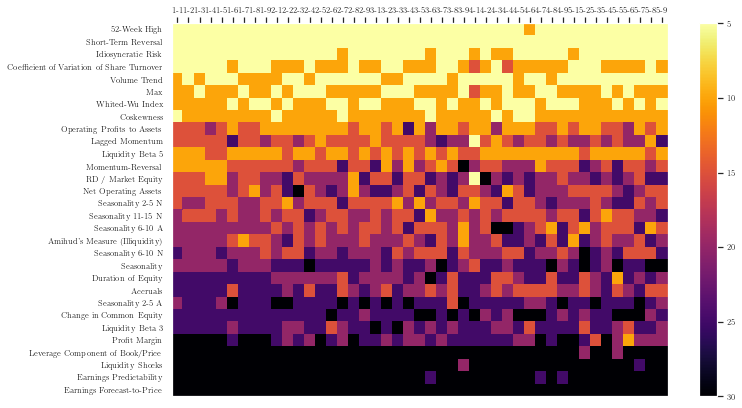

In [122]:
df = (ig.apply(lambda x: get_parts(x,6), axis=1))
df_heatmap(
    name(
        ar, 
        subset_models(
            ar, df, hidden_layers=None, ytrain=16
        ).transpose(),
        ["nn_name_short", "seed"]
    ),
    cmap=plt.cm.inferno_r,
    vmin=None,
    flip_cbar=True
)

### This is especially true for simple models. It is also visible in the figure above. This is the correlation of seeds within each NN (lines represnt multiple train-test splits).

<AxesSubplot:>

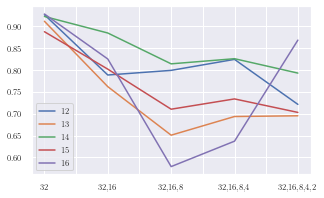

In [133]:
ig_corr = get_corr_of_seeds(ar, ig)
pd.DataFrame(ig_corr).plot()

### Model Reliance changes across seeds considerably (10 most important features)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


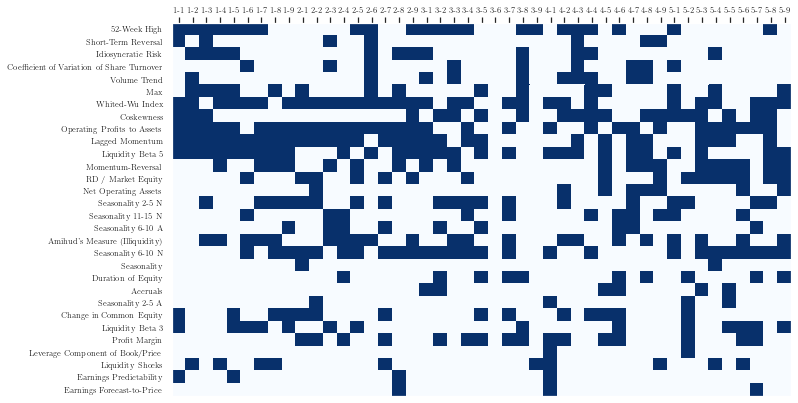

In [134]:
df = (mr.apply(lambda x: get_orders(x), axis=1)>=20)
df_heatmap(
    name(
        ar, 
        subset_models(
            ar, df, hidden_layers=None, ytrain=16
        ).transpose(),
        ["nn_name_short", "seed"]
    ),
    cmap=plt.cm.Blues,
    vmin=0,
    show_cbar=False
)

### Model Reliance changes across seeds considerably (features grouped by importance into categories of 5)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


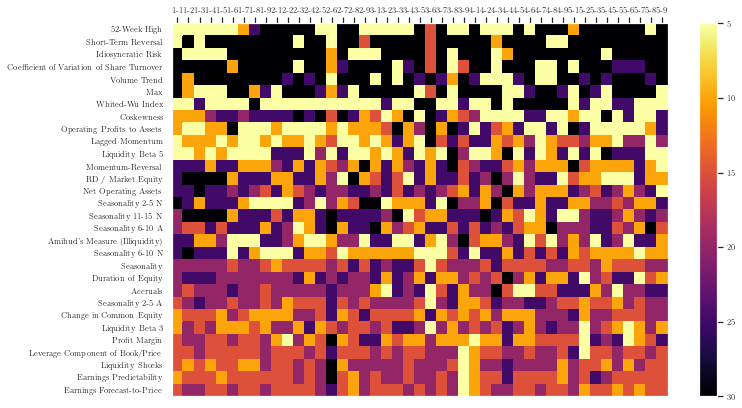

In [135]:
df = (mr.apply(lambda x: get_parts(x,6), axis=1))
df_heatmap(
    name(
        ar, 
        subset_models(
            ar, df, hidden_layers=None, ytrain=16
        ).transpose(),
        ["nn_name_short", "seed"]
    ),
    cmap=plt.cm.inferno_r,
    vmin=None,
    flip_cbar=True
)

### This is true especially for top features (zooming in the previous figure)

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


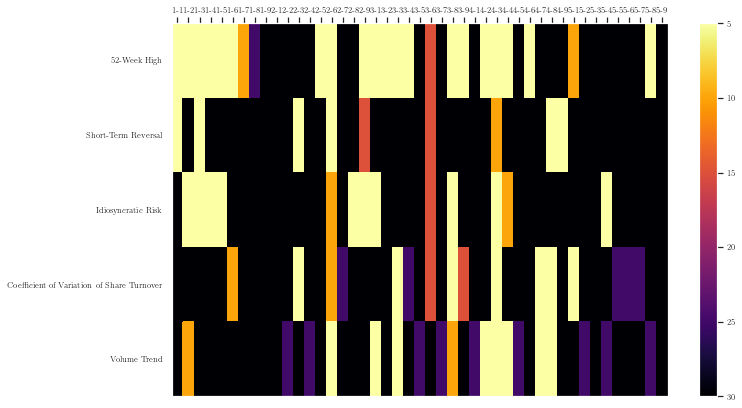

In [136]:
df = (mr.apply(lambda x: get_parts(x,6), axis=1))
df_heatmap(
    name(
        ar, 
        subset_models(
            ar, df, hidden_layers=None, ytrain=16
        ).transpose().head(5),
        ["nn_name_short", "seed"]
    ),
    cmap=plt.cm.inferno_r,
    vmin=None,
    vmax=30,
    flip_cbar=True
)

### Compare to IG

C:\Users\HP\Anaconda3\Lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


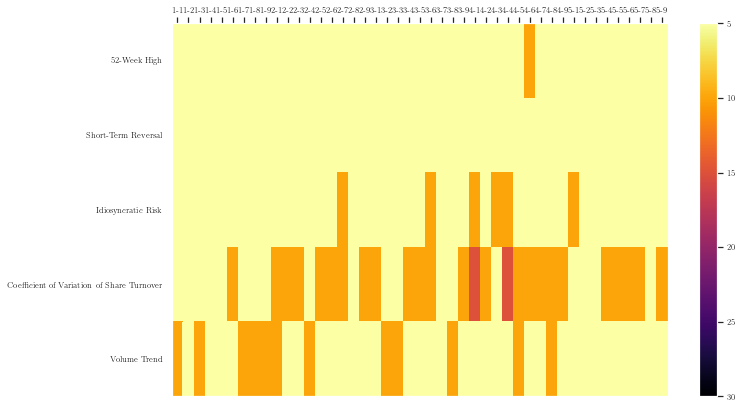

In [137]:
df = (ig.apply(lambda x: get_parts(x,6), axis=1))
df_heatmap(
    name(
        ar, 
        subset_models(
            ar, df, hidden_layers=None, ytrain=16
        ).transpose().head(5),
        ["nn_name_short", "seed"]
    ),
    cmap=plt.cm.inferno_r,
    vmin=None,
    vmax=30,
    flip_cbar=True
)